In [1]:
# import the general stuff
import os
from os import getcwd
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
from sklearn import metrics

#import the tf stuff
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model

from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Check TensorFlow Version
print('TF version: {}' .format(tf.__version__))


TF version: 2.3.0


In [2]:
#Check for GPU utilization
if tf.test.gpu_device_name():
    print(' GPU: {}'.format(tf.test.gpu_device_name()))
else:
    print("No GPU")

 GPU: /device:GPU:0


In [3]:
# define a callback

callbacks = tf.keras.callbacks.EarlyStopping(monitor = 'val_acc', 
                                             patience = 15, 
                                             restore_best_weights = True)

In [4]:
# Define dirs and files
train_dir = '../data/training/'
validation_dir = '../data/validation/'

train_wash_dir = os.path.join(train_dir,'wash')
train_nowash_dir = os.path.join(train_dir,'nowash')
validation_wash_dir = os.path.join(validation_dir,'wash')
validation_nowash_dir = os.path.join(validation_dir,'nowash')

train_wash_fnames = os.listdir(train_wash_dir)
train_nowash_fnames = os.listdir(train_nowash_dir)
validation_wash_fnames = os.listdir(validation_wash_dir)
validation_nowash_fnames = os.listdir(validation_nowash_dir)


print(len(os.listdir(train_wash_dir)))
print(len(os.listdir(train_nowash_dir)))
print(len(os.listdir(validation_wash_dir)))
print(len(os.listdir(validation_nowash_dir)))

total_train=len(os.listdir(train_wash_dir))+ len(os.listdir(train_nowash_dir))
total_val=len(os.listdir(validation_wash_dir))+ len(os.listdir(validation_nowash_dir))

144
167
37
42


In [5]:
#build data generators for training and validaton

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator( rescale =1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# rescale val data
val_datagen = ImageDataGenerator( rescale =1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

#set batch Size
batch_size = 16

#set Image size (RGB so imshape is 3)
pix_dim = 224
imsize = (pix_dim,pix_dim) 
imshape = (pix_dim,pix_dim,3)

# Flow training images in batches 
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = batch_size,
                                                    class_mode = 'binary',
                                                    target_size = imsize)

# Flow validation images in batches 
validation_generator =  val_datagen.flow_from_directory( validation_dir,
                                                         batch_size = batch_size,
                                                         class_mode = 'binary',
                                                         target_size = imsize)


Found 311 images belonging to 2 classes.
Found 79 images belonging to 2 classes.


In [6]:
# define the metrics
acc_metric = tf.keras.metrics.BinaryAccuracy(name='acc')

In [7]:
#base model, no top layer, w/ imagenet weights
base_model = tf.keras.applications.MobileNetV2(input_shape = imshape, 
                                             include_top = False, 
                                             weights = 'imagenet')

base_model.trainable = False
base_model.summary()


Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [8]:
# add a new classifcation layer

final_layer = base_model.get_layer('out_relu')
print('shape of last layer is ', final_layer.output_shape)
final_base_output = final_layer.output


#add the last layer
# Flatten the output layer to 1 dimension
x = layers.Flatten()(final_base_output )
# Add a fully connected layer with 1,024 hidden units and ReLU activation
# x = layers.Dense(1024, activation='relu', kernel_regularizer = 'l2')(x)
x = layers.Dense(1024, activation='relu', kernel_regularizer = tf.keras.regularizers.l2(1e-4))(x)
# x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)           

model = Model(base_model.input, x) 

model.summary()

shape of last layer is  (None, 7, 7, 1280)
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
____________________________________________

In [9]:
#build the model
model.compile(loss = 'binary_crossentropy',
              optimizer = tf.keras.optimizers.Adam(lr = 1e-5),
              metrics = acc_metric)

In [10]:
#train the model
history = model.fit(train_generator,
                              steps_per_epoch = total_train // batch_size,
                              validation_data = validation_generator,
                              epochs= 100,
                              validation_steps =  total_val // batch_size,
                              callbacks =[callbacks])

Epoch 1/100
19/19 [==============================] - 72s 4s/step - loss: 0.9199 - acc: 0.7831 - val_loss: 0.7674 - val_acc: 0.7812
Epoch 2/100
19/19 [==============================] - 68s 4s/step - loss: 0.6215 - acc: 0.8678 - val_loss: 0.4662 - val_acc: 0.8750
Epoch 3/100
19/19 [==============================] - 67s 4s/step - loss: 0.5596 - acc: 0.8678 - val_loss: 0.3780 - val_acc: 0.9062
Epoch 4/100
19/19 [==============================] - 68s 4s/step - loss: 0.4973 - acc: 0.8915 - val_loss: 0.4614 - val_acc: 0.8750
Epoch 5/100
19/19 [==============================] - 68s 4s/step - loss: 0.5222 - acc: 0.8881 - val_loss: 0.5236 - val_acc: 0.8906
Epoch 6/100
19/19 [==============================] - 66s 3s/step - loss: 0.5557 - acc: 0.8712 - val_loss: 0.4974 - val_acc: 0.8594
Epoch 7/100
19/19 [==============================] - 70s 4s/step - loss: 0.4394 - acc: 0.9085 - val_loss: 0.5479 - val_acc: 0.8906
Epoch 8/100
19/19 [==============================] - 70s 4s/step - loss: 0.4338 - a

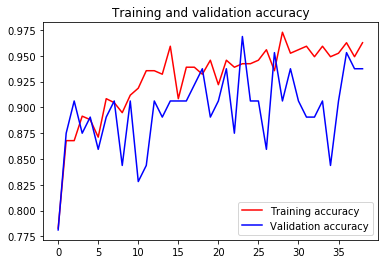

<Figure size 432x288 with 0 Axes>

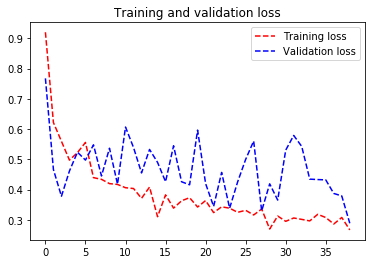

<Figure size 432x288 with 0 Axes>

In [11]:
#look at the metrics from training
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

plt.plot(epochs, loss, 'r--', label='Training loss')
plt.plot(epochs, val_loss, 'b--', label='Validation loss')
plt.title('Training and validation loss') 
plt.legend(loc=0)
plt.figure()
plt.show()

In [12]:
#save the model
filepath = './saved_MobileNetV2_r'
model.save(filepath)

#load model
# model = tf.keras.models.load_model(filepath, compile = True)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./saved_MobileNetV2_r/assets


In [15]:
#test the model

#define test directory
test_dir_wash = '../data/testing_michael/wash/'
test_dir_nowash = '../data/testing_michael/nowash'

#load images for wash
w_test = []
w_images = []
for img in os.listdir(test_dir_wash):
    #pull the name of the image
    w_images.append(img)
    #pull the image
    img = os.path.join(test_dir_wash, img)
    img = tf.keras.preprocessing.image.load_img(img,target_size = imsize)
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = img/255
    img = np.expand_dims(img,axis=0)
    w_test.append(img)

#load images for nowash
nw_test = []
nw_images = []
for img in os.listdir(test_dir_nowash):
    #pull the name of the image
    nw_images.append(img)
    #pull the image
    img = os.path.join(test_dir_nowash, img)
    img = tf.keras.preprocessing.image.load_img(img,target_size = imsize)
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = img/255
    img = np.expand_dims(img,axis=0)
    nw_test.append(img)


In [16]:
#make predictions 
w_test = np.vstack(w_test)
w_preds = model.predict(w_test)

nw_test = np.vstack(nw_test)
nw_preds = model.predict(nw_test)

In [17]:
#stack up the predicitons and truth in the same format

#vstack pred array
all_pred = np.vstack((w_preds,nw_preds))
all_pred = all_pred > 0.5

#vstack true array
all_obs = np.vstack((np.full((70,1), True), np.full((70,1), False)))

In [18]:
#report relevant binary classification stats for test data
report = metrics.classification_report(all_obs, all_pred)
print(report)

              precision    recall  f1-score   support

       False       0.80      0.94      0.86        70
        True       0.93      0.76      0.83        70

    accuracy                           0.85       140
   macro avg       0.86      0.85      0.85       140
weighted avg       0.86      0.85      0.85       140



In [19]:
#and the confusion matrix for test data
CM = metrics.confusion_matrix(all_obs, all_pred)
CM

array([[66,  4],
       [17, 53]])

In [20]:
#check the 4 categories of the Conf. Matrix
tn, fp, fn, tp = CM.ravel()
(tn, fp, fn, tp)

(66, 4, 17, 53)

In [21]:
#make labels into an array (wash then nowash)
nw_images = np.vstack((np.asarray(nw_images)))
w_images = np.vstack((np.asarray(w_images)))
all_images = np.vstack((w_images, nw_images))

#make single df for image names, true class, and predicted class 
#data = np.hstack((all_labels, all_true, all_pred))
results_df = pd.DataFrame(np.hstack((all_images, all_obs, all_pred)), columns=["Image", "Observed", "Predicted"])
results_df.head()

,Image,Observed,Predicted
0,P28462771.jpg,True,False
1,P28462380.jpg,True,True
2,P28463002.jpg,True,True
3,P28463062.jpg,True,True
4,P28463052.jpg,True,True


In [22]:
#save the df as a csv
results_df.to_csv('../data/test_results/mobilenetv2_r.csv', index=False)